# Transformer

In [7]:
from typing import List
import random

import sentencepiece as spm
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
from dlprog import train_progress
import matplotlib.pyplot as plt


---

## Self-Attention

In [ ]:
class SelfAttention(nn.Module):
    def forward(self, x):
        """
        x: (batch_size, seq_len, d_model)
        """
        scores = x @ x.mT # (batch_size, seq_len, seq_len)
        weights = F.softmax(scores, dim=-1)
        y = weights @ x # (batch_size, seq_len, d_model)
        return y


---

## Positional Encoding

In [2]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model: int, max_len: int = 1000, n: int = 10000):
        super().__init__()
        self.d_model = d_model
        self.max_len = max_len
        self.n = n
        pe = self._get_pe()
        self.register_buffer('pe', pe)

    def forward(self, length: int):
        pe = self.pe[:length, :]
        return pe

    def _get_pe(self):
        pos = torch.arange(0, self.max_len).unsqueeze(1)
        div = self.n ** (torch.arange(0, self.d_model, 2) / self.d_model)
        pe = torch.zeros(self.max_len, self.d_model)
        pe[:, 0::2] = torch.sin(pos / div)
        pe[:, 1::2] = torch.cos(pos / div)
        return pe

In [5]:
pe = PositionalEncoding(512)

In [6]:
pe(12).shape

torch.Size([12, 512])

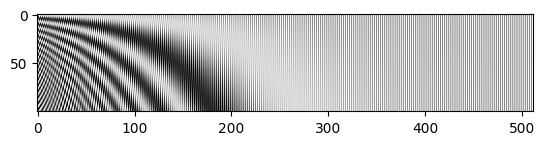

In [16]:
plt.imshow(pe(100).numpy(), cmap='gray');


---

## Query-Key-Value

In [ ]:
class Attention(nn.Module):
    def __init__(self, d_model: int):
        self.fc_q = nn.Linear(d_model, d_model)
        self.fc_k = nn.Linear(d_model, d_model)
        self.fc_v = nn.Linear(d_model, d_model)
        self.scale = 1 / (d_model ** 0.5)

    def forward(self, source, target, mask=None):
        """
        source: (batch_size, seq_len_s, d_model)
        target: (batch_size, seq_len_t, d_model)
        mask: (batch_size, seq_len_s, seq_len_t)
        """
        q = self.fc_q(source) # (batch_size, seq_len_s, d_model)
        k = self.fc_k(target) # (batch_size, seq_len_t, d_model)
        v = self.fc_v(target) # (batch_size, seq_len_t, d_model)
        scores = q @ k.mT * self.scale # (batch_size, seq_len_s, seq_len_t)
        if mask is not None:
            scores.masked_fill_(mask, -torch.inf)
        weights = F.softmax(scores, dim=-1)
        y = weights @ v # (batch_size, seq_len_s, d_model)
        return y


---

## Multi-Head Attention

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model: int, n_heads: int):
        d = d_model // n_heads
        self.fc_q = nn.Linear(d, d)
        self.fc_k = nn.Linear(d, d)
        self.fc_v = nn.Linear(d, d)
        self.fc_o = nn.Linear(d, d_model)
        self.n_heads = n_heads
        self.scale = 1 / (d ** 0.5)

    def forward(self, source, target, mask=None):
        q = self.fc_q(source) # (batch_size, seq_len_s, d_model)
        k = self.fc_k(target) # (batch_size, seq_len_t, d_model)
        v = self.fc_v(target) # (batch_size, seq_len_t, d_model)

        q = self._split(q) # (n_heads, batch_size, seq_len_s, d)
        k = self._split(k) # (n_heads, batch_size, seq_len_t, d)
        v = self._split(v) # (n_heads, batch_size, seq_len_t, d)

        scores = q @ k.mT * self.scale # (n_heads, batch_size, seq_len_s, seq_len_t)
        if mask is not None:
            scores.masked_fill_(mask, -torch.inf)
        weights = F.softmax(scores, dim=-1)
        y = weights @ v # (n_heads, batch_size, seq_len_s, d)

        y = self._concat(y) # (batch_size, seq_len_s, d_model)
        y = self.fc_o(y) # (batch_size, seq_len_s, d_model)
        return y

    def _split(self, x):
        y = torch.stack(torch.tensor_split(x, self.n_heads, dim=-1))
            # (n_heads, batch_size, seq_len, d)
        return y

    def _concat(self, x):
        y = torch.cat(torch.unbind(x, dim=0), dim=-1)
            # (batch_size, seq_len, d_model)
        return y


---

## Transformer

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, d_model: int, n_heads: int):
        super().__init__()
        